## Prepare data in Colab enviornment

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir data
! mkdir data/tid2013
! cp -r drive/MyDrive/Colab\ Notebooks/img-quality-assesment/data/tid2013/distorted_images ./data/tid2013/
! cp drive/MyDrive/Colab\ Notebooks/img-quality-assesment/data/tid2013/mos_with_names.txt ./data/tid2013/
! cp -r drive/MyDrive/Colab\ Notebooks/img-quality-assesment/nima .

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/tid2013’: File exists


#### Install libraries

In [1]:
! pip install livelossplot

In [22]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow.keras as keras

# Start : In local docker only
import sys
sys.path.append('/home/jovyan/work') 
# End : In local docker only

import nima as nima

### Load Dataset

In [2]:
from nima.utils.tid_dataset_utils import load_tid_data
from nima.config import DATASET_DIR
from nima.utils.ava_downloader import print_msg

p_dataset_dir = DATASET_DIR
p_model_name = 'vgg'
p_batch_size = 64
p_epochs = 10
p_sample_size=100
p_metrics = ['accuracy']
p_verbose = 1
p_freeze_base = True

tid_dataset_dir = os.path.join(p_dataset_dir, 'tid2013')
tid_images_dir = os.path.join(tid_dataset_dir, 'distorted_images')
img_format = 'bmp'
print_msg(f'Images directory {tid_images_dir}')

# Load the dataset
x_col, y_cols = 'image_id', 'rating'
df_train, df_valid, df_test = load_tid_data(tid_dataset_dir, p_sample_size)
assert len(df_train) > 0 and len(df_valid) > 0 and len(df_test) > 0, 'Empty dataframe'
train_batch_size = valid_batch_size = p_batch_size
test_batch_size = min(p_batch_size, 32, len(df_test))

df_train.head()

Images directory /home/jovyan/work/data/tid2013/distorted_images
Number of samples picked 100


,rating,image_id
0,5.90698,i21_14_1
1,4.73171,i04_21_2
2,5.46512,i13_10_2
3,5.58974,i22_07_1
4,3.25641,i17_15_3


In [3]:
df_train.describe()

,rating
count,72.000000
mean,4.691763
std,1.151795
min,0.756760
25%,4.021427
50%,4.798130
75%,5.658615
max,6.696970


### Create the model

In [4]:
from nima.model.model_builder import NIMA
from nima.config import INPUT_SHAPE, CROP_SHAPE
from tensorflow.keras.losses import mean_squared_error

# Form the NIMA Aesthetic Model
nima_technical_cnn = NIMA(base_model_name=p_model_name, weights='imagenet', model_type='technical',
                          
                            input_shape=INPUT_SHAPE, metrics=p_metrics)

# Build the model for training
nima_technical_cnn.build()
nima_technical_cnn.compile(train_layers=False)
nima_technical_cnn.model.summary()

Model's module - tensorflow.keras.applications.vgg19.VGG19
Model compiled successfully.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_______________________________________

### Create Model

In [5]:
from nima.model.data_generator import TrainDataGenerator

# Get the generator
train_generator = TrainDataGenerator(df_train, tid_images_dir, x_col=x_col, y_col=y_cols,
                                     img_format=img_format, num_classes=1,
                                     preprocess_input=nima_technical_cnn.preprocessing_function(),
                                     batch_size=train_batch_size, input_size=INPUT_SHAPE, crop_size=CROP_SHAPE)
valid_generator = TrainDataGenerator(df_valid, tid_images_dir, x_col, y_cols, img_format=img_format, num_classes=1,
                                     preprocess_input=nima_technical_cnn.preprocessing_function(),
                                     batch_size=train_batch_size, input_size=INPUT_SHAPE, crop_size=CROP_SHAPE)

Found 72 valid image filenames belonging to 1 classes.
Found 18 valid image filenames belonging to 1 classes.


##### Train the model

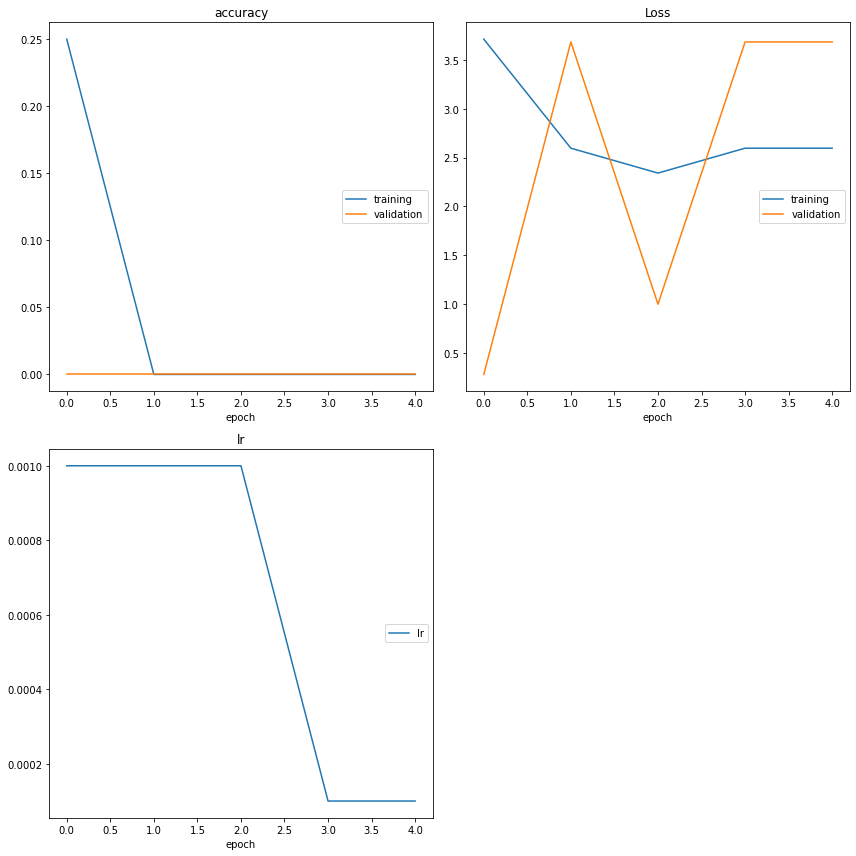

Epoch 00005: early stopping
Training Time (HH:MM:SS) : 00:08:35


In [6]:
train_result_df, train_weights_file = nima_technical_cnn.train_model(train_generator, valid_generator,
                                                                     epochs=p_epochs, verbose=p_verbose)

#### Test the model

In [34]:
from nima.model.data_generator import TestDataGenerator

print_msg(f'Testing Batch size {test_batch_size}', 1)
# Get the generator
test_generator = TestDataGenerator(df_test, tid_images_dir, x_col=x_col, y_col=None,
                                   img_format=img_format, num_classes=1,
                                   preprocess_input=nima_technical_cnn.preprocessing_function(),
                                   batch_size=test_batch_size, input_size=INPUT_SHAPE)

test_steps = np.ceil(len(test_generator) / test_batch_size)
predictions = nima_technical_cnn.model.predict(test_generator, steps=test_steps)
df_test['prediction'] = predictions
df_test

	Testing Batch size 10
Found 10 valid image filenames belonging to 1 classes.


,rating,image_id,prediction
0,3.56757,i19_01_5,0.0
1,5.67568,i12_16_5,0.0
2,5.42105,i10_19_2,0.0
3,2.34375,i09_10_5,0.0
4,5.77778,i02_19_1,0.0
5,3.50000,i25_07_1,0.0
6,3.19444,i01_03_4,0.0
7,1.73810,i13_08_5,0.0
8,4.39474,i10_05_4,0.0
9,3.12821,i16_09_4,0.0


#### Test the model for one image

<class 'PIL.BmpImagePlugin.BmpImageFile'>


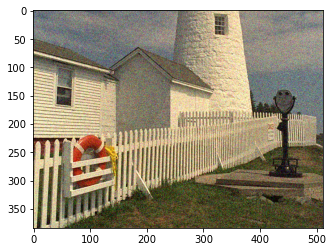

In [33]:
from nima.utils import image_utils
import matplotlib.pyplot as plt

image = df_test.iloc[0]['image_id']
y_true = df_test.iloc[0]['rating']

# Form image path
image_path = os.path.join(tid_images_dir, f'{image}.bmp')
# convert to numpy array
x = image_utils.load_img(image_path, INPUT_SHAPE)
print(type(x))
plt.imshow(x)

In [35]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

image = df_test.iloc[0]['image_id']
image_path = os.path.join(tid_images_dir, f'{image}.bmp')
target_size = INPUT_SHAPE

x = load_img(image_path, target_size=(target_size[0], target_size[1]))  # load the image in pillow format
x = img_to_array(x)  # convert to numpy array
x = x.reshape(1, *x.shape)
x = (nima_technical_cnn.preprocessing_function())(x)
x

array([[[[-30.939003 , -15.778999 , -15.68     ],
         [ 41.060997 ,  11.221001 , -29.68     ],
         [  8.060997 ,  -2.7789993,   6.3199997],
         ...,
         [ 68.061    ,  -4.7789993, -29.68     ],
         [ 52.060997 ,  -8.778999 ,  11.32     ],
         [ 54.060997 ,  64.221    , -22.68     ]],

        [[ 11.060997 ,   1.2210007,  15.32     ],
         [ 26.060997 ,  38.221    , -12.68     ],
         [  2.060997 , -14.778999 ,  -0.6800003],
         ...,
         [ 69.061    ,  -8.778999 ,   2.3199997],
         [ 41.060997 ,  16.221    ,  -7.6800003],
         [ -4.939003 ,  56.221    ,  44.32     ]],

        [[ 30.060997 ,   2.2210007,  -2.6800003],
         [ 31.060997 , -29.779    , -30.68     ],
         [ 60.060997 ,  -9.778999 , -17.68     ],
         ...,
         [  6.060997 ,  62.221    ,  20.32     ],
         [ 28.060997 ,  32.221    ,  72.32     ],
         [  1.060997 ,  13.221001 ,   3.3199997]],

        ...,

        [[ 70.061    ,  99.221    ,  9

In [32]:
predict = nima_technical_cnn.model.predict(x)
predict

array([[0.]], dtype=float32)